# Emotion Detection


**Importing Libraries**


In [3]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)


Tensorflow version: 2.13.0


# Exploring Dataset


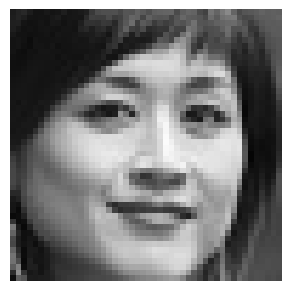

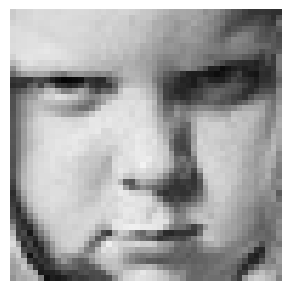

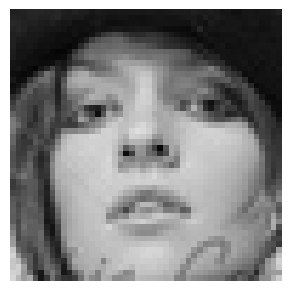

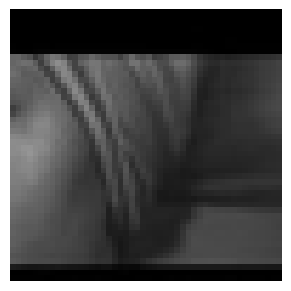

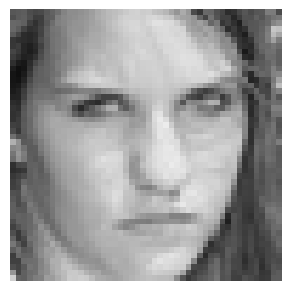

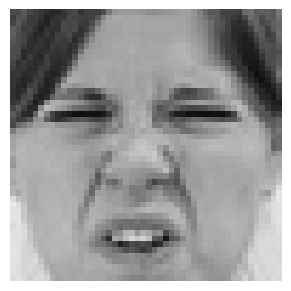

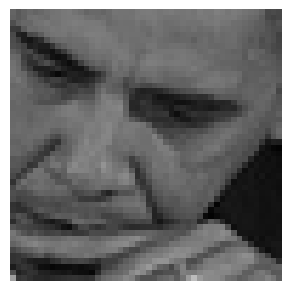

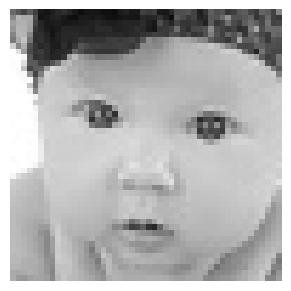

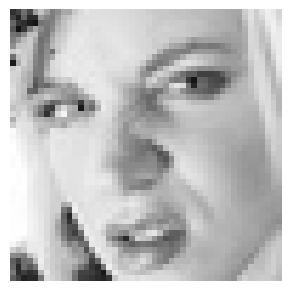

In [4]:
Images = glob("Train/**/**")
for i in range(9):
    image = random.choice(Images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

**Preparing Data for Training**

In [8]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()

train_generator=datagen_train.flow_from_directory("train/",
                                                  target_size = (img_size,img_size),
                                                  color_mode = "grayscale", 
                                                 batch_size = batch_size, 
                                                  class_mode = "categorical", 
                                                  shuffle = True)

datagen_validation = ImageDataGenerator()
Validation_generator=datagen_train.flow_from_directory("train/", target_size = (img_size,img_size), color_mode = "grayscale", 
                                                   batch_size = batch_size, class_mode = "categorical", shuffle = True)

Found 28709 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.


**Defining Model**

In [13]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)

    return x

In [14]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [15]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 32, (3,3))
    conv_2 = Convolution(inputs, 64, (5,5))
    conv_3 = Convolution(inputs, 128, (3,3))
    
    flatten = Flatten()(conv_3)
    
    dense_1 = Dense_f(flatten, 256)
    
    output = Dense(7, activation="softmax")(dense_1)
    
    model = Model(inputs = [inputs], outputs = [output])
    model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [16]:
model = model_fer((48,48,1))
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       1280      
                                                                 
 batch_normalization_2 (Bat  (None, 48, 48, 128)       512       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 48, 48, 128)       0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 128)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 128)       0     

**Initilizing the Model**

In [21]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = Validation_generator.n//Validation_generator.batch_size

Checkpoint = ModelCheckpoint("model_weights.h5", monitor = "val_accuracy", save_weights_only = True, mode = 'max', verbose =1)
callbacks = [Checkpoint]

# Training the Model

**The next step takes time to complete**

In [24]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = Validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/15
448/448 [==============================] - ETA: 0s - loss: 0.9499 - accuracy: 0.6539
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 1827s 4s/step - loss: 0.9499 - accuracy: 0.6539 - val_loss: 0.9704 - val_accuracy: 0.6462
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 0.8107 - accuracy: 0.7105
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 1744s 4s/step - loss: 0.8107 - accuracy: 0.7105 - val_loss: 1.0393 - val_accuracy: 0.6044
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 0.6444 - accuracy: 0.7760
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 1467s 3s/step - loss: 0.6444 - accuracy: 0.7760 - val_loss: 0.6896 - val_accuracy: 0.7504
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 0.5078 - accuracy: 0.8283
Epoch 4: saving model to model_weights.h5
448/448 [==============================] - 1486s 

**Model Evaluation**

In [25]:
model.evaluate(Validation_generator)

449/449 [==============================] - 215s 476ms/step - loss: 0.1755 - accuracy: 0.9416


[0.17545633018016815, 0.9415514469146729]

**Plotting Loss**

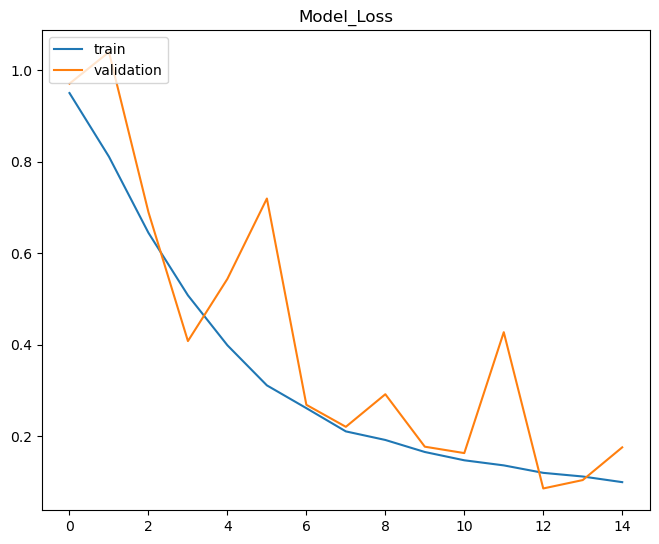

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_Loss')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

**Model Accuracy**

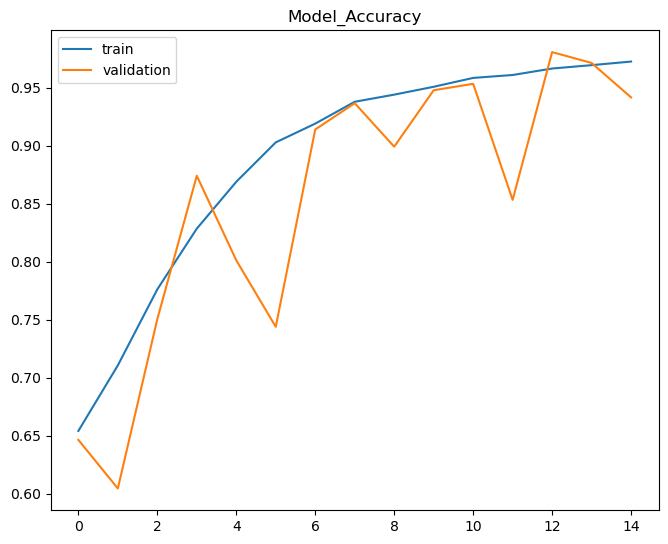

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model_Accuracy')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

**Saving Model**

In [31]:
model_json = model.to_json()
with open("model_a.json", "w") as json_file:
    json_file.write(model_json)